# **Análise de impacto de aspectos sócioeconômicos sobre o desempenho de alunos do Exame Nacional do Ensino Médio de 2020.**

<p align = 'justify'>O Exame Nacional do Ensino médio, comumente chamado de ENEM, é um exame aplicado nacionalmente a partir de 1998 visando avaliar o desempenho de egressos do ensino médio brasileiro e, atualmente, serve como ferramenta de avaliativa de para acesso ao ensino superior público e privado e técnico pós-médio. O exame evoluiu junto da universalização do ensino médio e da oferta de vagas no ensino superior, reunindo 9.276.328 de alunos em 2015, sendo 59 vezes o número de inscritos na primeira edição (157.221).</p>

## **Obtenção dos dados**
<p align = 'justify'>No momento na inscrição para o exame, perguntas com foco em avaliação socioeconômica são aplicadas aos participantes, as respostas são compiladas em uma base de dados e disponibilizada anualmente pelo Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (INEP) em seu site junto do dicionário dos dados, arquivos das provas e gabaritos etc.</p>
<p align = 'justify'>Os dados podem ser acessados no <a href = "https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem">Portal Inep</a> conforme cada ano de aplicação.</p>

<p align = 'justify'>Para esse projeto, a base selecionada foi a do exame de 2020 devido ser a mais recente até junho de 2022.</p>

**Descrição da base**
<p> A base possui 5.783.109 linhas e 74 colunas. Dentre essas, foram selecionadas as seguintes variáveis:</p>


> 
*   NU_INSCRICAO - Número de inscrição do participante
*   TP_DEPENDENCIA_ADM_ESC - Dependência administrativa da escola que o participante cursou o ensino médio
*   TP_LOCALIZACAO_ESC - 
*   SG_UF_ESC - Estado da escola que o participante cursou o ensino médio
*   TP_ESCOLA - Tipo da escola que o participante cursou o ensino médio
*   TP_SEXO - Sexo do participante
*   TP_FAIXA_ETARIA - Faixa etaria do participante
*   TP_COR_RACA - Cor/raça do participante
*   NU_NOTA_CN - Nota da prova de Ciências da Natureza
*   NU_NOTA_CH - Nota da prova de Ciências Humanas
*   NU_NOTA_LC - Nota da prova de Linguagens e Códigos
*   NU_NOTA_MT - Nota da prova de Matemática
*   TP_PRESENCA_CN - Presença na prova objetiva de Ciências da Natureza
*   TP_PRESENCA_CH - Presença na prova objetiva de Ciências Humanas
*   TP_PRESENCA_LC - Presença na prova objetiva de Linguagens e Códigos
*   TP_PRESENCA_MT - Presença na prova objetiva de Matemática
*   NU_NOTA_REDACAO - Nota da prova de redação
*   Q002 - Nível de escolaridade materna
*   Q004 - Ocupação laboral materna
*   Q006 - Renda familiar mensal
*   Q024 - O candidato possui computador da residência?
*   Q025 - A residência do candidato possui acesso à internet?
*   REGIAO - Macroregião a que pertence  candidato
*   NU_MEDIA - Média aritmética das notas de natureza, linguagens, humanas, matemática e redação.


<p align = 'justify'>Cabe destacar que as variáveis REGIAO e NU_MEDIA, não existem na base de dados original, sendo a prmeira responsável por agrupar os estados dos candidatos em macroregiões (Norte, Nordeste, Centro-Oeste, Sudeste e Sul), enquanto que a variável NU_MEDIA é aritmética das notas de matemática, linguagens, humanas, natureza e redação.</p>

#Instalação e carregamento de pacotes

> O primeiro passo relizar instalação e carregamento das bibliotecas, além de obteer e importar os dados que serão utliados.



In [ ]:
if(!require(data.table)){install.packages('data.table')} # Intalação do pacote Data.Table

install.packages("tidyverse") 
install.packages("nlme")
install.packages("lmtest") #através da função lrtest permite a comparação de dois modelos usando Likelihood ratio test.
install.packages("msm") # atavés da função Função LogLik permite mensurar acurácia de um modelo de regresão. Função também presente no pacote nlme
#install.packages("lmeInfo")
install.packages("jtools")
install.packages("reshape2")
#install.packages("car")
install.packages("googledrive")
install.packages("httpuv")
library(tidyverse)
library(nlme)
library(lmtest)
library(msm)
#library(lmeInfo)
library(jtools)
library(reshape2)
#library(car)
library(googledrive) 
library(httpuv)

**Acesso aos arquivos pelo Google Drive**
> Como mencionado, o colab não roda o ambiente R por padrão, para que seja possível acessar os arquivos armazenados na nuvem é necessário a adição de algumas bibliotecas extras.
* A library httr permitira o mapeamento do protocolo http para conexão com o drive onde está armazenado os dados.
* R.utils permitirá o gerênciamento da sessão da conexão com o local do arquivo.

In [6]:
# Verifique se está rodando no Colab e redefina is_interactive() 
if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")) { 
  install.packages(" R.utils") 
  library("R.utils") 
  library("httr") 
  my_check <- function() {return(TRUE)} 
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE ) 
}

> Ao executar a próxima linha será solicitado a chave de acesso para o armazenamento do drive.

In [ ]:
drive_auth(use_oob = TRUE, cache = TRUE)

**Algorítmo para avaliação de p-value**
> A função abaixo tem por objetivo avaliar o **valor-p** dos termos de erro do modelo multinível.
A significância do termo de erro indica se a melhor estratégia a ser seguida é a modelagem multinível ou a regressão linear múltipla.
> Gostaria de mencionar e agredecer ao **professor Rafael de Freitas**, da universidade de São Paulo, por disponibilizar esse algorítmo que facilita em muito a análise dos erros do modelo.

In [ ]:
stderr_nlme <- function(model){
  if(base::class(model) != "lme"){
    base::message("Use a lme object model from nlme package")
    stop()}
  resume <- base::summary(model)
  if(base::length(base::names(model$groups))==1){
    m.type <- "HLM2"
  } else if(base::length(base::names(model$groups))==2){
    m.type <- "HLM3"
  }
  if(m.type == "HLM2"){
    vcov_matrix <- model$apVar
    logs_sd_re <- base::attr(vcov_matrix,"Pars")
    if(base::length(logs_sd_re)==2){
      stderr_tau00 <- msm::deltamethod(~exp(x1)^2,logs_sd_re,vcov_matrix)
      stderr_sigma <- msm::deltamethod(~exp(x2)^2,logs_sd_re,vcov_matrix)
      results <- base::data.frame(`RE Components`=base::c("Var(v0j)","Var(e)"),
                                  `Variance Estimatives`= base::c(base::exp(logs_sd_re)[[1]]^2,
                                                                  base::exp(logs_sd_re[[2]])^2),
                                  `Std Err.`=base::c(stderr_tau00,
                                                     stderr_sigma),
                                  z=base::c(base::exp(logs_sd_re)[[1]]^2/stderr_tau00,
                                            base::exp(logs_sd_re[[2]])^2/stderr_sigma),
                                  `p-value`=base::round(stats::pnorm(q=base::c(base::exp(logs_sd_re)[[1]]^2/stderr_tau00,
                                                                               base::exp(logs_sd_re[[2]])^2/stderr_sigma),
                                                                     lower.tail=F)*2,3))
      return(results)
    }
    else{
      stderr_tau00 <- msm::deltamethod(~exp(x1)^2,logs_sd_re,vcov_matrix)
      stderr_tau01 <- msm::deltamethod(~exp(x2)^2,logs_sd_re,vcov_matrix)
      stderr_sigma <- msm::deltamethod(~exp(x4)^2,logs_sd_re,vcov_matrix)
      results <- base::data.frame(Components=base::c("Var(v0j)","Var(v1j)","Var(e)"),
                                  Estimatives= base::c(base::exp(logs_sd_re)[[1]]^2,
                                                       base::exp(logs_sd_re[[2]])^2,
                                                       base::exp(logs_sd_re[[4]])^2),
                                  Std_Err=base::c(stderr_tau00,
                                                  stderr_tau01,
                                                  stderr_sigma),
                                  z=base::c(base::exp(logs_sd_re)[[1]]^2/stderr_tau00,
                                            base::exp(logs_sd_re[[2]])^2/stderr_tau01,
                                            base::exp(logs_sd_re[[4]])^2/stderr_sigma),
                                  `p-value`=base::round(stats::pnorm(q=base::c(base::exp(logs_sd_re)[[1]]^2/stderr_tau00,
                                                                               base::exp(logs_sd_re[[2]])^2/stderr_tau01,
                                                                               base::exp(logs_sd_re[[4]])^2/stderr_sigma),
                                                                     lower.tail=F)*2,3))
      return(results)
    }
  }
  if(m.type == "HLM3"){
    vcov_matrix <- model$apVar
    logs_sd_re <-  base::attr(vcov_matrix,"Pars")
    if(base::length(logs_sd_re) == 3){
      stderr_tau_r000 <- msm::deltamethod(~exp(x1)^2,logs_sd_re,vcov_matrix)
      stderr_tau_u000 <- msm::deltamethod(~exp(x2)^2,logs_sd_re,vcov_matrix)
      stderr_sigma <- msm::deltamethod(~exp(x3)^2,logs_sd_re,vcov_matrix)
      results <- base::data.frame(Components=base::c("Var(t00k)","Var(v0jk)","Var(e)"),
                                  Estimatives=base::c(base::exp(logs_sd_re)[[2]]^2,
                                                      base::exp(logs_sd_re)[[1]]^2,
                                                      base::exp(logs_sd_re)[[3]]^2),
                                  Std_Err=base::c(stderr_tau_u000,
                                                  stderr_tau_r000,
                                                  stderr_sigma),
                                  z=base::c(base::exp(logs_sd_re)[[2]]^2/stderr_tau_u000,
                                            base::exp(logs_sd_re)[[1]]^2/stderr_tau_r000,
                                            base::exp(logs_sd_re)[[3]]^2/stderr_sigma),
                                  `p-value`=base::round(stats::pnorm(q=base::c(base::exp(logs_sd_re)[[2]]^2/stderr_tau_u000,
                                                                               base::exp(logs_sd_re)[[1]]^2/stderr_tau_r000,
                                                                               base::exp(logs_sd_re)[[3]]^2/stderr_sigma),
                                                                     lower.tail=F)*2,3))
      return(results)
    } 
    else{
      stderr_tau_r000 <- msm::deltamethod(~exp(x1)^2,logs_sd_re,vcov_matrix)
      stderr_tau_r100 <- msm::deltamethod(~exp(x2)^2,logs_sd_re,vcov_matrix)
      stderr_tau_u000 <- msm::deltamethod(~exp(x4)^2,logs_sd_re,vcov_matrix)
      stderr_tau_u100 <- msm::deltamethod(~exp(x5)^2,logs_sd_re,vcov_matrix)
      stderr_sigma <- msm::deltamethod(~exp(x7)^2,logs_sd_re,vcov_matrix)
      results <- base::data.frame(`RE_Components`=base::c("Var(t00k)","Var(t10k)",
                                                          "Var(v0jk)","Var(v1jk)",
                                                          "Var(e)"),
                                  `Variance Estimatives`=base::c(base::exp(logs_sd_re)[[4]]^2,
                                                                 base::exp(logs_sd_re)[[5]]^2,
                                                                 base::exp(logs_sd_re)[[1]]^2,
                                                                 base::exp(logs_sd_re)[[2]]^2,
                                                                 base::exp(logs_sd_re)[[7]]^2),
                                  `Std Err.`=base::c(stderr_tau_u000,
                                                     stderr_tau_u100,
                                                     stderr_tau_r000,
                                                     stderr_tau_r100,
                                                     stderr_sigma),
                                  z=base::c(base::exp(logs_sd_re)[[4]]^2/stderr_tau_u000,
                                            base::exp(logs_sd_re)[[5]]^2/stderr_tau_u100,
                                            base::exp(logs_sd_re)[[1]]^2/stderr_tau_r000,
                                            base::exp(logs_sd_re)[[2]]^2/stderr_tau_r100,
                                            base::exp(logs_sd_re)[[7]]^2/stderr_sigma),
                                  `p-value`=base::round(stats::pnorm(q=base::c(base::exp(logs_sd_re)[[4]]^2/stderr_tau_u000,
                                                                               base::exp(logs_sd_re)[[5]]^2/stderr_tau_u100,
                                                                               base::exp(logs_sd_re)[[1]]^2/stderr_tau_r000,
                                                                               base::exp(logs_sd_re)[[2]]^2/stderr_tau_r100,
                                                                               base::exp(logs_sd_re)[[7]]^2/stderr_sigma),
                                                                     lower.tail=F)*2,3))
      return(results)
    }
  }
}

# Carregamento e limpeza dos dados

**Importando os dados a partir da núvem**
> Após realizado a configuração e o acesso ao drive com o arquivo, é hora de importarmos os dados.
Para isso executamos o download direto no da pasta do drive, o arquivo é importado para área de conteúdo e por fim usados pacotes de leitura de arquivos como o data.table. A escolha pela função fread invés do read_csv, presente no tidyverse, é sua velocidade para carregar arquivos na ordem de Gigabytes, como é o caso aqui. 


In [ ]:
x <- drive_get("~/TCC/Dados/MICRODADOS_ENEM_2020.csv")
drive_download(x) 





✔ The input `path` resolved to exactly 1 file.

File downloaded:

• MICRODADOS_ENEM_2020.csv <id: 1XC0szVdqE88A-j0FtQ47Au-qVebau9ub>

Saved locally as:

• MICRODADOS_ENEM_2020.csv



In [15]:
base2020 <- fread(input = "/content/MICRODADOS_ENEM_2020.csv",
                  integer64='character',
                  skip=0,  #Ler do inicio
                  nrows = -1, #Ler todos os registros
                  na.strings = "", 
                  showProgress = TRUE,
                  encoding = "UTF-8")

Warning message in fread(input = url, integer64 = "character", skip = 0, nrows = -1, :
“Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”
Warning message in fread(input = url, integer64 = "character", skip = 0, nrows = -1, :
“Detected 17 column names but the data has 19 columns (i.e. invalid file). Added 2 extra default column names at the end.”
Warning message in fread(input = url, integer64 = "character", skip = 0, nrows = -1, :
“Stopped early on line 43. Expected 19 fields but found 33. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<L.prototype.G=function(){L.P.G.call(this);if(this.u){var a=this.u,b=0,c;for(c in a.g){for(var d=a.g[c],e=0;e<d.length;e++)++b,J(d[e]);delete a.g[c];a.h--}}this.h=null};var M=function(a,b,c,d){b=a.u.g[String(b)];if(!b)return!0;b=b.concat();for(var e=!0,f=0;f<b.length;++f){var k=b[f];if(k&&!k.J&&k.capture=

**Seleção de variáveis para análise e modelagem**
> Nesse ponto selecoinamos as variáveis da base de dados que serão utilizadas na análise e na modelagem. Essa etapa é importante considerando  o número de observações em nossa base(5.783.109 x 74), reduzir o número de colunas na base, reduz o tamanho do arquivo a ser armazenamento na memória.
> Além disso, foram acrescidos a base as variáveis de Média total das notas e região do participante.

In [ ]:
variaveis <- c(
  "NU_INSCRICAO",
  "SG_UF_ESC",
"TP_DEPENDENCIA_ADM_ESC",  # Factor
"TP_LOCALIZACAO_ESC",  # Factor
"TP_FAIXA_ETARIA", # facor
"TP_SEXO", # Factor
"TP_ESCOLA", # Factor
"TP_COR_RACA",  # Factor
"TP_PRESENCA_CN", # Factor
"TP_PRESENCA_CH", # Factor
"TP_PRESENCA_LC", # Factor
"TP_PRESENCA_MT", # Factor
"NU_NOTA_CN", # Numeric
"NU_NOTA_CH", # Numeric
"NU_NOTA_LC", # Numeric
"NU_NOTA_MT", # Numeric
"TP_LINGUA", # Factor
"NU_NOTA_REDACAO", # Numeric
"Q001", # Factor
"Q002", # Factor
"Q003", # Factor
"Q004", # Factor
"Q005", # Factor
"Q006", # Factor
"Q024", # Factor
"Q025" # Factor
)

In [ ]:
base2020 <- base2020[,..variaveis]

In [ ]:
base2020$NU_MEDIA <- (base2020$NU_NOTA_CN + base2020$NU_NOTA_CH + 
                        base2020$NU_NOTA_LC + base2020$NU_NOTA_MT + 
                        base2020$NU_NOTA_REDACAO) / 5



In [ ]:
norte <- c("AM", "AC", "RO", "PA", "RR", "TO", "AP")
centro_oeste <- c("MT", "GO", "DF", "MS")
nordeste <- c("MA", "CE", "RN", "PB", "PE", "AL", "SE", "BA", "PI")
sudeste <- c("MG", "ES", "SP", "RJ")
sul <- c("PR", "SC", "RS")

base2020 <- base2020 %>%
  mutate(ifelse(SG_UF_ESC %in% norte, "Norte",
                ifelse(SG_UF_ESC %in% centro_oeste, "Centro Oeste",
                       ifelse(SG_UF_ESC %in% nordeste, "Nordeste",
                              ifelse(SG_UF_ESC %in% sudeste, "Sudeste",
                                     ifelse(SG_UF_ESC %in% sul, "Sul", "x")))))) %>% 
  rename(REGIAO = 34)
base2020$REGIAO <- factor(base2020$REGIAO)

**Aplicação de filtros**
> Após seleção das variáveis e substancial redução no número de features, aplicaremos filtros com o objetivo de manter somente os dados de interesse para o estudo.

> Ao todo, **seis filtros** foram aplicados:
* Faltaram nos dias de exame
* Desclassificados na redação ou nota igual a 0
* Tipo de escola não informado
* Estudantes com dados ausentes
* Candidatos com informações divergentes
* Delimitação da faixa etária

In [ ]:

#Total de observações = 5.783.109
# Selecionando somente aqueles compareceram a todos os dias de prova

base2020 <- base2020[base2020$TP_PRESENCA_CN != 0] # 2598866 candidatos
base2020 <- base2020[base2020$TP_PRESENCA_CH != 0] # 2590358 candidatos
base2020 <- base2020[base2020$TP_PRESENCA_LC != 0] # 2590358 candidatos
base2020 <- base2020[base2020$TP_PRESENCA_CH != 0] # 2590358 candidatos
base2020 <- base2020[as.numeric(base2020$NU_NOTA_REDACAO, na.rm = T) != 0] # 2531126 candidatos

# Selecionando somente aqueles resposnderam o Tipo de escola que cursaram o Ens.m?dio
base2020 <- base2020[base2020$TP_ESCOLA != 1] # 794778 candidatos
base2020 <- base2020[base2020$TP_ESCOLA != 4] # 794778 candidatos

#Deletando todos as observa??es como missing values em ao menos uma das colunas. 
#A base apresenta valores NA como character, sendo necess?rio suas transforma??es em Missing Values.
base2020[base2020 == "NA"] <- NA
base2020 <- na.omit(base2020) # 509871 candidatos

#Deletando candidatos com dependência administrativa e tipo escola cruzados.
base2020 <- base2020 %>%
  filter(
    (TP_ESCOLA == "2" & TP_DEPENDENCIA_ADM_ESC != "4") | (TP_ESCOLA == "3" & TP_DEPENDENCIA_ADM_ESC == "4") 
  ) #475805 candidatos

#Filtro para idades relevantes 17 e 25 anos
base_teste <- base2020 %>%
  filter(
    (TP_FAIXA_ETARIA != 1 ) & (TP_FAIXA_ETARIA < 11 )
    )

## Ao todo, a base de dados sofre uma redução de quase 92%.

Após a limpeza e seleção de dedos foi notado que:
1. 3.192.751 faltaram ao menos um dia de exame em 2020 (55% da base)
2. 59.232 foram desclassificados da redação (1%)
3. 1.736.348 não informaram o tipo da escola. (30%)
4. 284.907 participantes não responderam questões principais no formulário socioecnomico, como raça, sexo, tipo da escola, escolaridade ou ocupação materna.(5%)
5. 34.066 apresentaram informações divergentes quanto ao tipo de escola em que estudou, se pública ou privada. (1%)
6. **xxxx apresentavam idade superior a 25 anos, sendo esse um agrupamento minoritário da base. (xxx %)**

> Ao todo, a base de dados sofreu uma redução de 93%. Sendo a o total de observações válidas para análise **475.805**.

> Por fim, realizamos a conversão das features para o tipo específico que os dados representam, considerando que os dados podem não ter sido classificados automaticamente.

In [ ]:
base2020$TP_COR_RACA <- as.factor(base2020$TP_COR_RACA)
base2020$TP_ESCOLA <- as.factor(base2020$TP_ESCOLA)
base2020$TP_SEXO <- as.factor(base2020$TP_SEXO)
base2020$Q002 <- as.factor(base2020$Q002)
base2020$Q025 <- as.factor(base2020$Q025)
base2020$TP_ENSINO <- as.factor(base2020$TP_ENSINO)
base2020$Q006 <- as.factor(base2020$Q006)
base2020$TP_DEPENDENCIA_ADM_ESC <- factor(base2020$TP_DEPENDENCIA_ADM_ESC)

#Análise Descritiva da base

TP_ESCOLA,Tipo de Escola,Média do grupo
<fct>,<int>,<dbl>
2,336949,518.9195
3,138856,613.4918


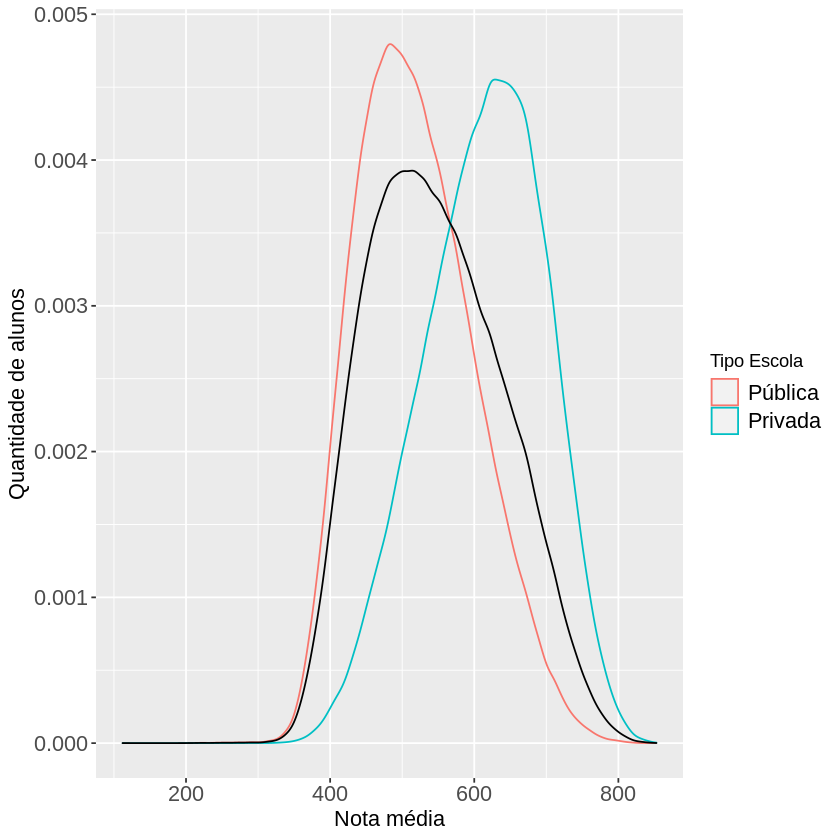

In [ ]:

# Quantidade de Alunos por tipo de escola(Pública - 2;Particular - 3)
base2020 %>% 
  group_by(TP_ESCOLA) %>% 
  summarise('Tipo de Escola' = n(),
            'Média do grupo' = mean(NU_MEDIA))

#Densidade da média dos alunos em função do tipo de escola.
base2020 %>% 
  ggplot(aes(x = NU_MEDIA)) +
  geom_density(aes(group = TP_ESCOLA, color = factor(TP_ESCOLA, labels = c("Pública", "Privada")))) +
  geom_density()+ # Acrescido posteriormente, em caso de erro retirar essa linha
  labs(x = 'Nota média', 
       y = 'Quantidade de alunos',
       color = 'Tipo Escola', element_text(size = 14)) +
  theme(axis.title = element_text(size = 13),
  axis.text = element_text(size = 13),
  legend.text = element_text(size = 13))


In [ ]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3696416,197.5,32569540,1739.5,28852724,1541.0
Vcells,401785073,3065.4,1220753030,9313.7,1220577009,9312.3


In [ ]:
#Distribuição de desemepnho por Dependência Administrativa
base2020 %>% 
  group_by(TP_DEPENDENCIA_ADM_ESC) %>% 
  summarise('Total' = n(),
            '% Base' = round(n()/nrow(base2020)*100),
            'Média Nacional' = mean(NU_MEDIA),
            'Percentil 10%' = quantile(NU_MEDIA, 0.10) ,           
            'Quartil 25%' = quantile(NU_MEDIA, 0.25),
            'Quartil 50%' = quantile(NU_MEDIA, 0.50),
            'Quartil 75%' = quantile(NU_MEDIA, 0.75),
            'Percentil 90%' = quantile(NU_MEDIA, 0.90))

TP_DEPENDENCIA_ADM_ESC,Total,% Base,Média Nacional,Percentil 10%,Quartil 25%,Quartil 50%,Quartil 75%,Percentil 90%
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,37130,8,595.6527,487.560,540.340,599.00,653.180,697.322
2,296035,62,509.1452,416.420,453.280,502.78,559.280,611.560
3,3784,1,530.6673,423.464,467.845,528.77,589.265,637.836
4,138856,29,613.4918,499.100,556.080,619.20,674.840,717.940


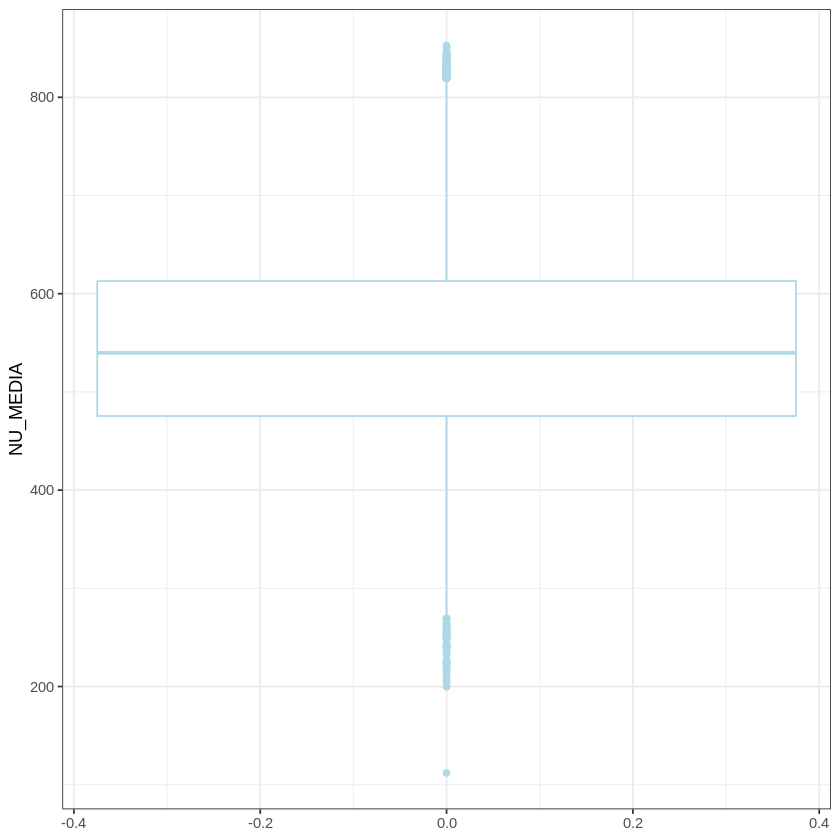

In [ ]:
base2020 %>% 
group_by(TP_DEPENDENCIA_ADM_ESC) %>%
ggplot(aes(y = NU_MEDIA)) + 
geom_boxplot(col="lightblue") + 
theme_bw()

In [ ]:
base2020[base2020$NU_MEDIA == min(base2020$NU_MEDIA) ]

NU_INSCRICAO,NU_ANO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,TP_ESTADO_CIVIL,⋯,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,NU_MEDIA,REGIAO
<chr>,<int>,<chr>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,⋯,<fct>,<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<fct>,<dbl>,<fct>
200006110451,2020,MG,2,1,2,M,2,1,1,⋯,C,B,B,3,E,D,A,B,112,Sudeste


In [ ]:
#Distribuição de desemepnho por região e tipo de escola
base2020 %>% 
  group_by(TP_ESCOLA, REGIAO) %>% 
  summarise('Total' = n(),
            '% Base' = n()/nrow(base2020)*100,
            'Média Nacional' = mean(NU_MEDIA))


`summarise()` has grouped output by 'TP_ESCOLA'. You can override using the
`.groups` argument.


TP_ESCOLA,REGIAO,Total,% Base,Média Nacional
<fct>,<fct>,<int>,<dbl>,<dbl>
2,Centro Oeste,31165,6.549952,518.9239
2,Nordeste,125280,26.330114,503.2645
2,Norte,33666,7.075588,495.4239
2,Sudeste,106880,22.462984,538.6462
2,Sul,39958,8.397978,535.0301
3,Centro Oeste,12248,2.574164,617.8492
3,Nordeste,37454,7.871712,604.5812
3,Norte,6953,1.461313,599.3081
3,Sudeste,66192,13.911581,618.0207


`geom_smooth()` using formula 'y ~ x'



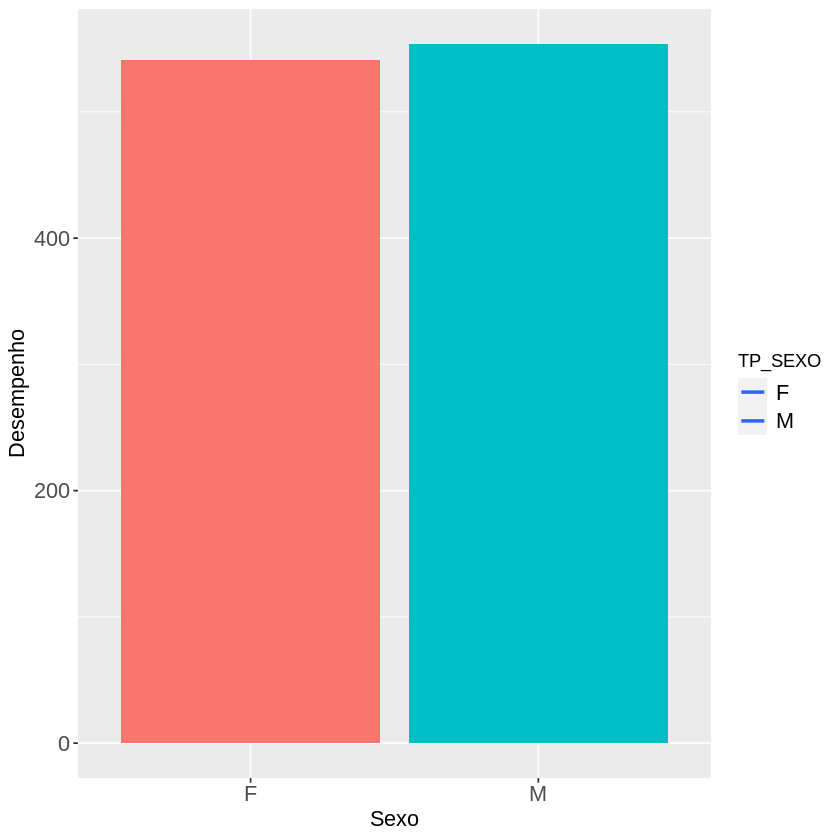

In [ ]:
#Média por sexo
base2020 %>% 
  group_by(TP_SEXO) %>%
  summarise('Desempenho' = mean(NU_MEDIA)) %>%
  ggplot(aes(x = TP_SEXO, y = Desempenho, fill = TP_SEXO)) +
  geom_col(position = "dodge", show.legend = FALSE) + 
  geom_smooth(aes(x = TP_SEXO, y = Desempenho, fill = TP_SEXO), method = "lm", se = FALSE) + 
  labs(x = 'Sexo') +
  theme(axis.title = element_text(size = 13),
  axis.text = element_text(size = 13),
  legend.text = element_text(size = 13))

In [ ]:
# Distribuição por faixa de renda 
base2020 %>% 
  group_by(Q006) %>% 
  summarise(
    'Total' = n(),
    '% Base' = n()/nrow(base2020)*100,
    'Média' = mean(NU_MEDIA)) %>%
  arrange(desc(Média)) %>% 
  rename('Faixa de renda?' = Q006)

Faixa de renda?,Total,% Base,Média
<fct>,<int>,<dbl>,<dbl>
Q,11626,2.443438,661.9695
P,8989,1.889219,647.6651
O,8689,1.826168,638.0723
N,9200,1.933565,631.1185
M,9506,1.997877,624.7214
L,6541,1.374723,618.1613
K,8430,1.771734,612.7889
J,10624,2.232847,606.4835
I,16687,3.507109,598.7522


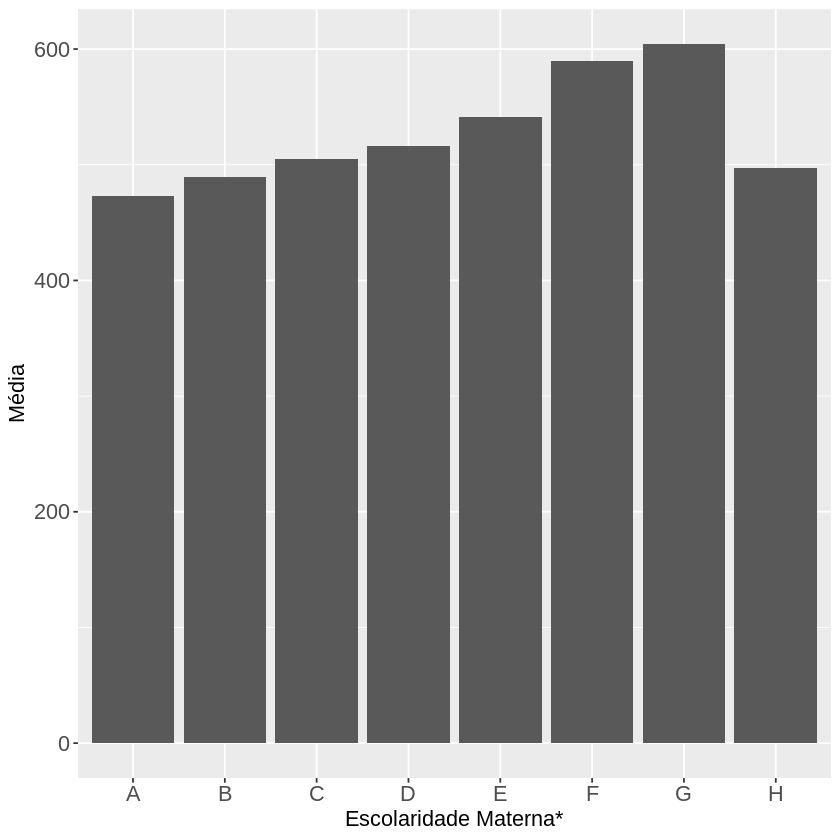

In [ ]:
# Desempenho em função do grau de escolaridade da mãe
# Média por Faixa de Renda da Mãe
base2020 %>% 
  group_by(Q002) %>% 
  summarise(
    'Total' = n(),
    '% Base' = n()/nrow(base2020)*100,
    'Média' = mean(NU_MEDIA)) %>%
  rename('Escolaridade Materna' = Q002) %>%
  ggplot(aes(x = `Escolaridade Materna`, y = Média)) +
  geom_col(position = "dodge", show.legend = FALSE) +
  labs(x = 'Escolaridade Materna*',) +
  theme(axis.title = element_text(size = 13),
  axis.text = element_text(size = 13),
  legend.text = element_text(size = 13))

In [ ]:
#Desempenho em função da especialização laboral da mãe ou resposnável mulher
base2020 %>% 
  group_by(Q004) %>% 
  summarise(
    'Total' = n(),
    '% Base' = n()/nrow(base2020)*100,
    'Média' = mean(NU_MEDIA)) %>%
  arrange(Média) %>% 
  rename('Escolaridade_Materna' = Q004)

Escolaridade_Materna,Total,% Base,Média
<chr>,<int>,<dbl>,<dbl>
A,51679,10.135701,487.2865
B,186278,36.534339,527.4390
F,41508,8.140883,535.0773
C,31951,6.266487,535.1405
D,159006,31.185535,580.1483
E,39449,7.737055,628.3993


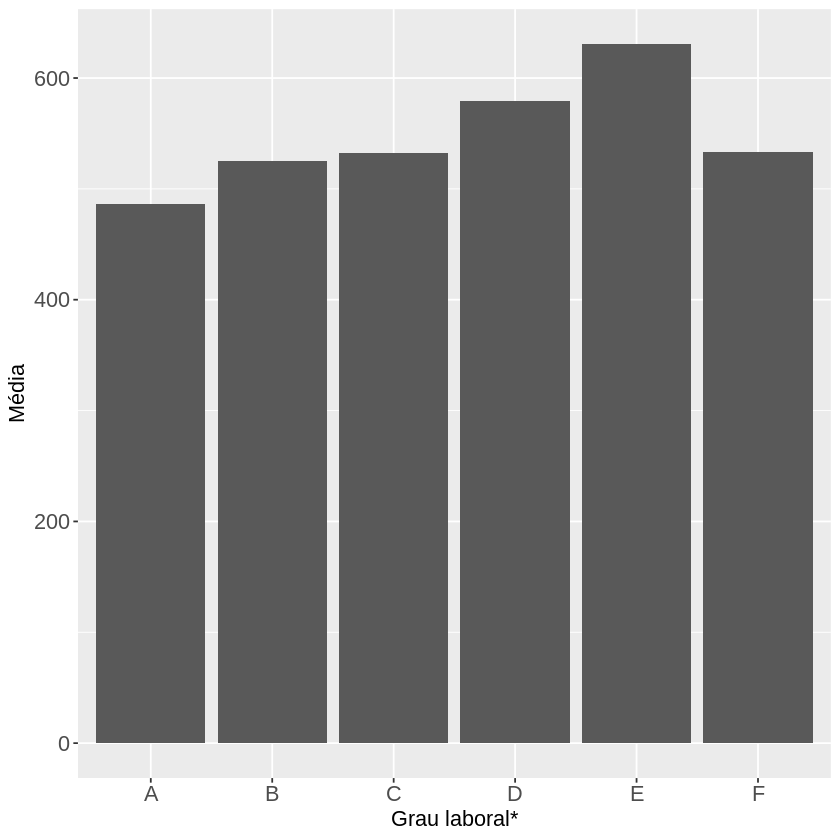

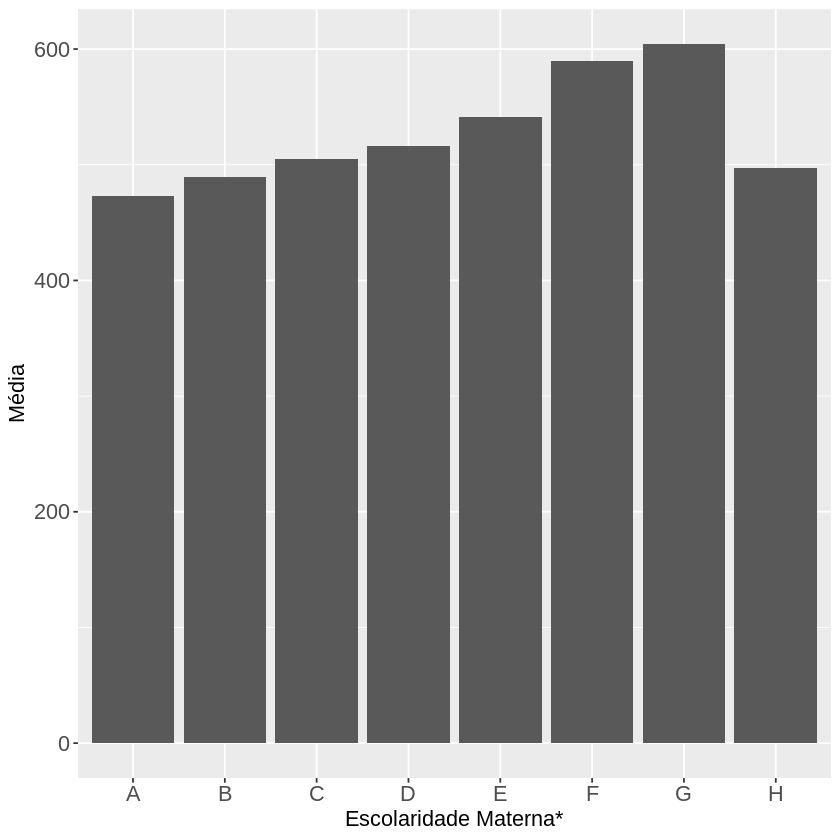

In [ ]:
#Desempenho em função do grau laboral da mãe
base2020 %>% 
  group_by(Q004) %>% 
  summarise(
    'Total' = n(),
    '% Base' = n()/nrow(base2020)*100,
    'Média' = mean(NU_MEDIA)) %>%
  rename('Grau laboral' = Q004) %>%
  ggplot(aes(x = `Grau laboral`, y = Média)) +
  geom_col(position = "dodge", show.legend = FALSE) +
  labs(x = 'Grau laboral*',) +
  theme(axis.title = element_text(size = 13),
  axis.text = element_text(size = 13),
  legend.text = element_text(size = 13))


base2020 %>%  
  group_by(Q002) %>% 
  summarise(
    'Total' = n(),
    '% Base' = n()/nrow(base2020)*100,
    'Média' = mean(NU_MEDIA)) %>%
  rename('Escolaridade Materna' = Q002) %>%
  ggplot(aes(x = `Escolaridade Materna`, y = Média)) +
  geom_col(position = "dodge", show.legend = FALSE) + 
  labs(x = 'Escolaridade Materna',) +
  theme(axis.title = element_text(size = 13),
  axis.text = element_text(size = 13),
  legend.text = element_text(size = 13))


# Modelagem com dados de 2020


In [ ]:
modelo_HLM2_Nulo <- lme(fixed = NU_MEDIA ~ 1 , 
                         random = ~ 1 | TP_DEPENDENCIA_ADM_ESC,
                         data = base_teste,
                         method = "ML",
                         control=list(msMaxIter=1000,
                                      msMaxIter = 100000, msMaxEval = 100000, opt = "nlminb",
                                      msVerbose=TRUE, sing.tol = 1e-20))

summary(modelo_HLM2_Nulo)

  0:     5079506.4: 0.583129
  1:     5079506.4: 0.583129


Linear mixed-effects model fit by maximum likelihood
  Data: base_teste 
      AIC     BIC   logLik
  5390237 5390270 -2695116

Random effects:
 Formula: ~1 | TP_DEPENDENCIA_ADM_ESC
        (Intercept) Residual
StdDev:    43.44203 77.83229

Fixed effects:  NU_MEDIA ~ 1 
               Value Std.Error     DF  t-value p-value
(Intercept) 562.5093   21.7237 466801 25.89381       0

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-5.31955165 -0.72171699 -0.02966901  0.69980100  4.05369371 

Number of Observations: 466805
Number of Groups: 4 

In [ ]:
summary(modelo_HLM2_Nulo)


Linear mixed-effects model fit by maximum likelihood
  Data: base_teste 
      AIC     BIC   logLik
  5390237 5390270 -2695116

Random effects:
 Formula: ~1 | TP_DEPENDENCIA_ADM_ESC
        (Intercept) Residual
StdDev:    43.44203 77.83229

Fixed effects:  NU_MEDIA ~ 1 
               Value Std.Error     DF  t-value p-value
(Intercept) 562.5093   21.7237 466801 25.89381       0

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-5.31955165 -0.72171699 -0.02966901  0.69980100  4.05369371 

Number of Observations: 466805
Number of Groups: 4 

In [ ]:
# Correlação intraclasse pelo modelo nulo
(43.44203^2)/ ((43.44203^2) +  (77.83229^2))

[1] 0.237532

In [ ]:
stderr_nlme(modelo_HLM2_Nulo)

RE.Components,Variance.Estimatives,Std.Err.,z,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Var(v0j),1887.210,1331.51600,1.417339,0.156
Var(e),6057.865,12.53917,483.115291,0.000


In [ ]:
modelo_OLS_Nulo <- lm(formula = NU_MEDIA ~ 1 ,
                 data = base_teste)

In [ ]:
lrtest(modelo_OLS_Nulo, modelo_HLM2_Nulo)

Warning message in modelUpdate(objects[[i - 1]], objects[[i]]):
“original model was of class "lm", updated model is of class "lme"”


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,-2772310,NA,NA,NA
2,3,-2695116,1,154388.6,0


In [ ]:
#Modelo somente com intercepto
modelo_HLM2_Intercepto <- lme(fixed = NU_MEDIA ~ TP_FAIXA_ETARIA + Q006 + Q002 + TP_COR_RACA, 
                         random = ~ 1 | TP_DEPENDENCIA_ADM_ESC,
                         data = base_teste,
                         method = "ML",
                         control=list(msMaxIter=1000,
                                      msMaxIter = 100000, msMaxEval = 100000, opt = "nlminb",
                                      msVerbose=TRUE, sing.tol = 1e-20))

  0:     5042946.6: 0.863891
  1:     5042946.6: 0.863891


In [ ]:
summary(modelo_HLM2_Intercepto)

Linear mixed-effects model fit by maximum likelihood
  Data: base_teste 
      AIC     BIC   logLik
  5317176 5317529 -2658556

Random effects:
 Formula: ~1 | TP_DEPENDENCIA_ADM_ESC
        (Intercept) Residual
StdDev:    30.33642  71.9693

Fixed effects:  NU_MEDIA ~ TP_FAIXA_ETARIA + Q006 + Q002 + TP_COR_RACA 
                   Value Std.Error     DF   t-value p-value
(Intercept)     535.5203 15.233689 466772  35.15369  0.0000
TP_FAIXA_ETARIA -11.9087  0.140255 466772 -84.90748  0.0000
Q006B            11.1076  0.533118 466772  20.83524  0.0000
Q006C            25.7513  0.573627 466772  44.89216  0.0000
Q006D            31.1052  0.592401 466772  52.50700  0.0000
Q006E            39.3115  0.650486 466772  60.43409  0.0000
Q006F            42.0090  0.638136 466772  65.83077  0.0000
Q006G            49.0983  0.662438 466772  74.11753  0.0000
Q006H            55.1600  0.703406 466772  78.41846  0.0000
Q006I            60.5595  0.786108 466772  77.03710  0.0000
Q006J            65.0078  0

In [ ]:
stderr_nlme(modelo_HLM2_Intercepto)

RE.Components,Variance.Estimatives,Std.Err.,z,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Var(v0j),920.2983,557.34458,1.65122,0.099
Var(e),5179.5803,10.72121,483.11530,0.000


In [ ]:
#base2020$TP_FAIXA_ETARIA <- as.numeric(base2020$TP_FAIXA_ETARIA)
modelo_HLM2 <- lme(fixed = NU_MEDIA ~ TP_FAIXA_ETARIA +  Q006 + Q002 + TP_COR_RACA, 
                         random = ~ TP_FAIXA_ETARIA | TP_DEPENDENCIA_ADM_ESC,
                         data = base_teste,
                         method = "REML",
                         control=list(msMaxIter=1000,
                                      msMaxIter = 100000, msMaxEval = 100000, opt = "nlminb",
                                      msVerbose=TRUE, sing.tol = 1e-20))

  0:     5042373.8:  1.05283  2.35205 -1.67807
  1:     5042373.8:  1.05283  2.35205 -1.67807
  2:     5042373.8:  1.05283  2.35205 -1.67807


In [ ]:
summary(modelo_HLM2)

Linear mixed-effects model fit by REML
  Data: base_teste 
      AIC     BIC   logLik
  5316370 5316746 -2658151

Random effects:
 Formula: ~TP_FAIXA_ETARIA | TP_DEPENDENCIA_ADM_ESC
 Structure: General positive-definite, Log-Cholesky parametrization
                StdDev    Corr  
(Intercept)     25.410903 (Intr)
TP_FAIXA_ETARIA  6.843957 0.158 
Residual        71.909931       

Fixed effects:  NU_MEDIA ~ TP_FAIXA_ETARIA + Q006 + Q002 + TP_COR_RACA 
                   Value Std.Error     DF   t-value p-value
(Intercept)     532.9544 12.816211 466772  41.58440  0.0000
TP_FAIXA_ETARIA -11.2131  3.441825 466772  -3.25790  0.0011
Q006B            11.0077  0.532692 466772  20.66425  0.0000
Q006C            25.6044  0.573285 466772  44.66256  0.0000
Q006D            30.9430  0.592117 466772  52.25833  0.0000
Q006E            39.1513  0.650154 466772  60.21849  0.0000
Q006F            41.8880  0.637764 466772  65.67936  0.0000
Q006G            49.0203  0.662027 466772  74.04575  0.0000
Q006H

In [ ]:
stderr_nlme(modelo_HLM2)

Components,Estimatives,Std_Err,z,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Var(v0j),645.71400,492.51145,1.311064,0.190
Var(v1j),46.83974,19.60363,2.389340,0.017
Var(e),5171.03814,10.70389,483.099020,0.000


In [ ]:
#Modelo Final OLS
#Modelo OLS 
modelo_OLS_Final <- lm(formula = NU_MEDIA ~ TP_FAIXA_ETARIA + Q006 + Q002 +  TP_COR_RACA,
                 data = base_teste)

summary(modelo_OLS_Final)


Call:
lm(formula = NU_MEDIA ~ TP_FAIXA_ETARIA + Q006 + Q002 + TP_COR_RACA, 
    data = base_teste)

Residuals:
    Min      1Q  Median      3Q     Max 
-417.73  -54.34   -3.26   51.93  308.25 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     498.7633     1.4377 346.922  < 2e-16 ***
TP_FAIXA_ETARIA -10.0662     0.1460 -68.926  < 2e-16 ***
Q006B            12.1344     0.5625  21.573  < 2e-16 ***
Q006C            29.9407     0.6049  49.494  < 2e-16 ***
Q006D            38.1276     0.6242  61.081  < 2e-16 ***
Q006E            49.1806     0.6848  71.822  < 2e-16 ***
Q006F            55.9967     0.6698  83.603  < 2e-16 ***
Q006G            67.0124     0.6932  96.676  < 2e-16 ***
Q006H            78.3197     0.7324 106.937  < 2e-16 ***
Q006I            86.9578     0.8178 106.337  < 2e-16 ***
Q006J            93.4045     0.9354  99.851  < 2e-16 ***
Q006K            98.2265     1.0131  96.960  < 2e-16 ***
Q006L           102.8868     1.1083  92.833  < 2e-

In [ ]:
lrtest(modelo_OLS_Final, modelo_HLM2)

Warning message in modelUpdate(objects[[i - 1]], objects[[i]]):
“original model was of class "lm", updated model is of class "lme"”


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,31,-2683605,NA,NA,NA
2,34,-2658151,3,50908.3,0


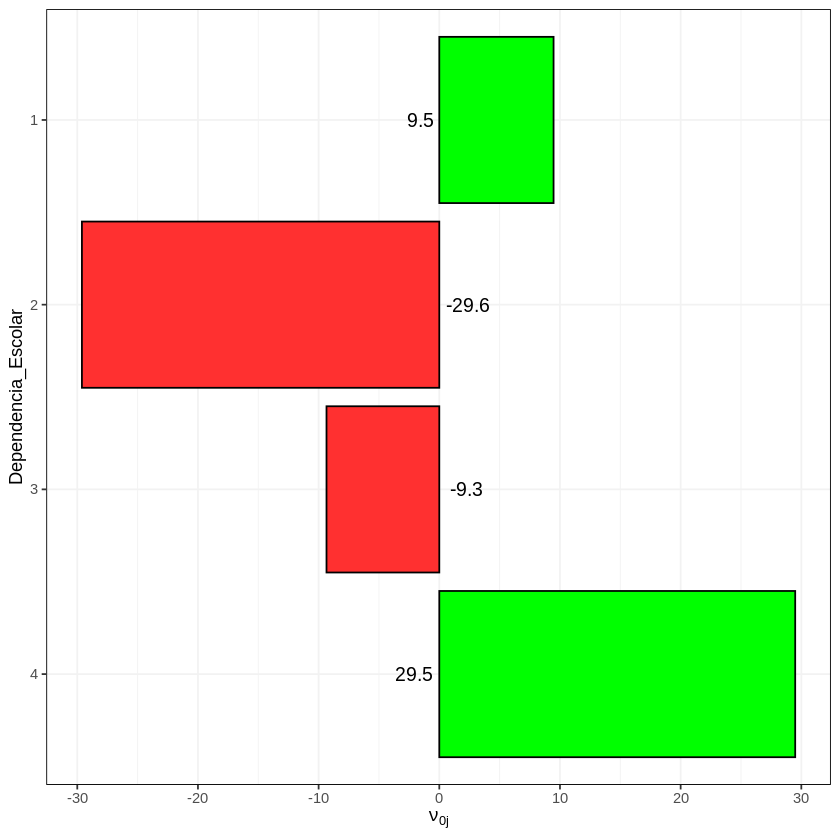

In [ ]:
# Para observarmos graficamente o comportamento dos valores de v0j, ou seja,
# dos interceptos aleatórios por escola, podemos comandar
random.effects(modelo_HLM2) %>% 
  rename(v0j = 1) %>% 
  rownames_to_column("Dependencia_Escolar") %>% 
  mutate(color_v0j = ifelse(v0j < 0, "A", "B"),
         hjust_v0j = ifelse(v0j > 0, 1.15, -0.15)) %>% 
  arrange(Dependencia_Escolar) %>% 
  ggplot(aes(label = format(v0j, digits = 2), 
             hjust = hjust_v0j)) +
  geom_bar(aes(x = fct_rev(Dependencia_Escolar), y = v0j, fill = color_v0j),
           stat = "identity", color = "black") +
  geom_text(aes(x = Dependencia_Escolar, y = 0), size = 4.1, color = "black") +
  coord_flip() +
  labs(x = "Dependencia_Escolar",
       y = expression(nu[0][j])) +
  scale_fill_manual("oi", values = c("firebrick1","green1")) +
  theme(panel.background = element_rect("white"),
        panel.border = element_rect(NA),
        panel.grid = element_line("grey95"),
        legend.position = "none")


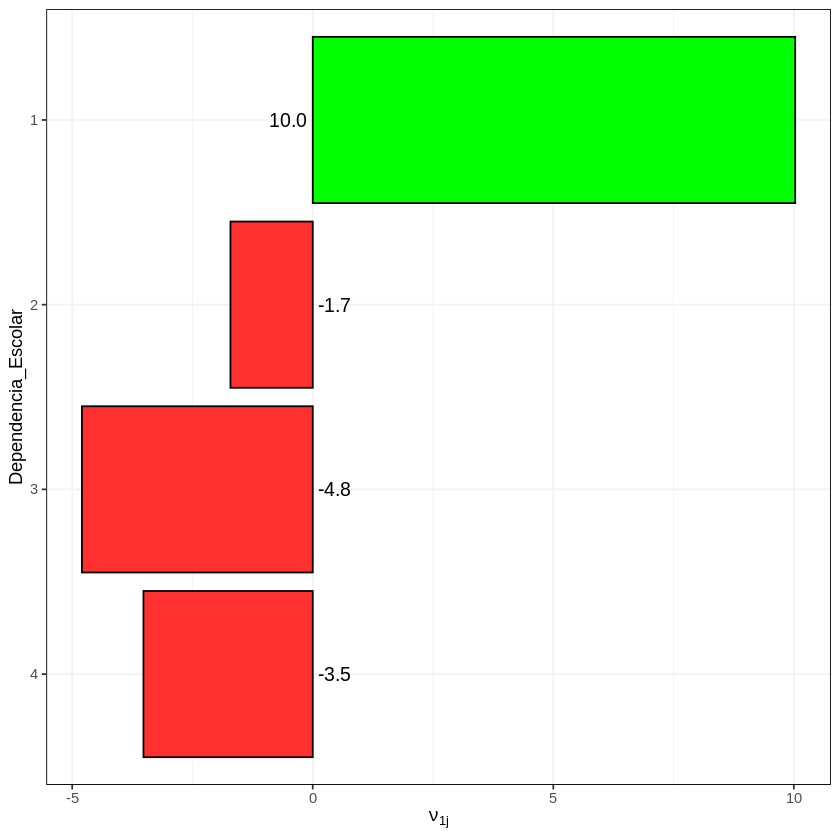

In [ ]:
# Para observarmos graficamente o comportamento dos valores de v1j, ou seja
# das comportamento das inclinações aleatórias por escola, podemos comandar
random.effects(modelo_HLM2) %>% 
  rename(v1j = 2) %>% 
  rownames_to_column("Dependencia_Escolar") %>% 
  mutate(color_v1j = ifelse(v1j < 0, "A", "B"),
         hjust_v1j = ifelse(v1j > 0, 1.15, -0.15)) %>% 
  arrange(Dependencia_Escolar) %>% 
  ggplot(aes(label = format(v1j, digits = 2), 
             hjust = hjust_v1j)) +
  geom_bar(aes(x = fct_rev(Dependencia_Escolar), y = v1j, fill = color_v1j),
           stat = "identity", color = "black") +
  geom_text(aes(x = Dependencia_Escolar, y = 0), size = 4.1, color = "black") +
  coord_flip() +
  labs(x = "Dependencia_Escolar",
       y = expression(nu[1][j])) +
  scale_fill_manual("oi", values = c("firebrick1","green1")) +
  theme(panel.background = element_rect("white"),
        panel.border = element_rect(NA),
        panel.grid = element_line("grey95"),
        legend.position = "none")


`geom_smooth()` using formula 'y ~ x'



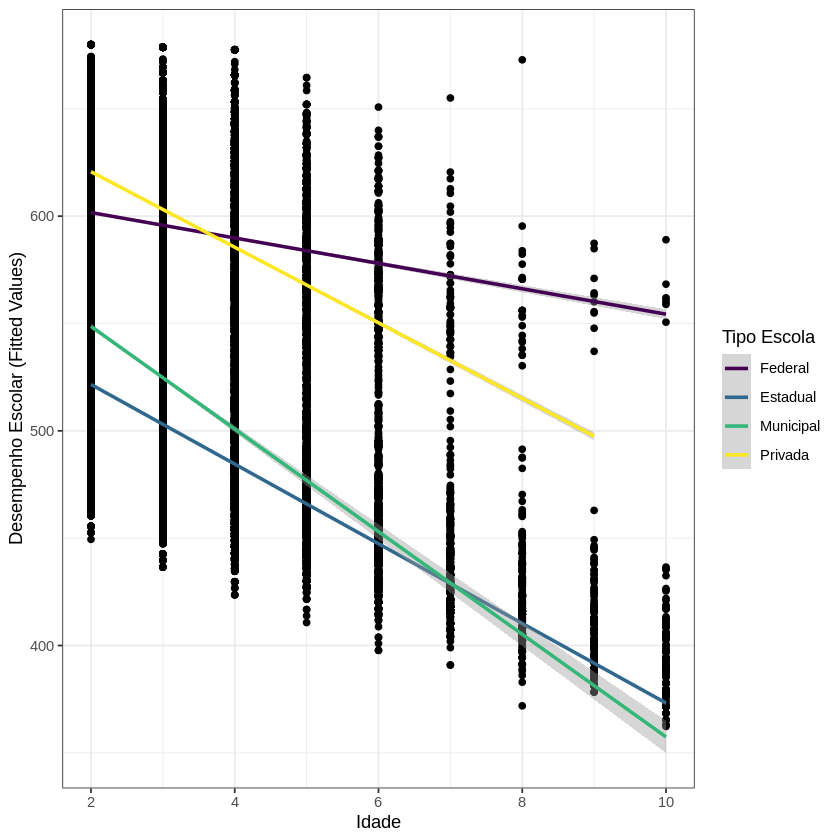

In [ ]:

#Valores previstos do desempenho escolar em função da variável d renda para o 
#modelo final HLM2 com interceptos e inclinações aleatórios
base_teste %>%
  mutate(fitted_Tipo_escola = predict(modelo_HLM2, level = 1)) %>% 
#  Q002 = as.factor(Q002)
  ggplot() +
  geom_point(aes(x = as.numeric(TP_FAIXA_ETARIA), y = fitted_Tipo_escola)) +
  geom_smooth(aes(x = as.numeric(TP_FAIXA_ETARIA), y = fitted_Tipo_escola, color = factor(TP_DEPENDENCIA_ADM_ESC, labels = c("Federal", "Estadual", "Municipal", "Privada"))), 
              method = "lm", se = T) +
  scale_colour_viridis_d() +
  labs(x = "Idade",
       y = "Desempenho Escolar (Fitted Values)",
        color = 'Tipo Escola', element_text(size = 14)) +
  theme_bw()

In [ ]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3727333,199.1,17904561,956.3,22380701,1195.3
Vcells,403933623,3081.8,1220780697,9313.9,1220590346,9312.4


#Comparação e análise dos resultados


[1] 409488 407711

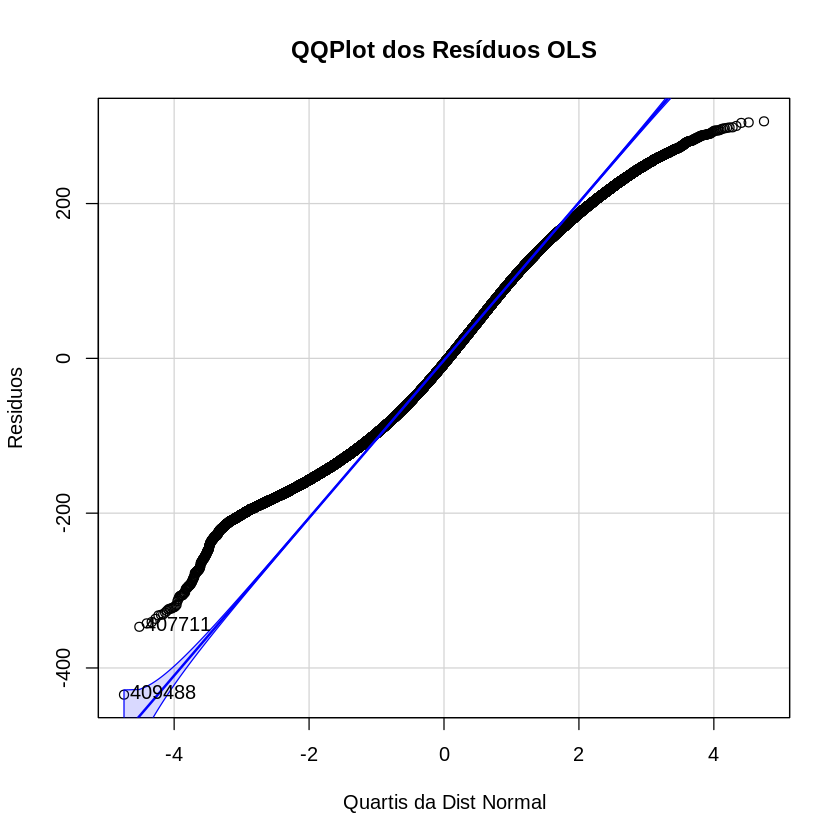

4      4 
407711 475048

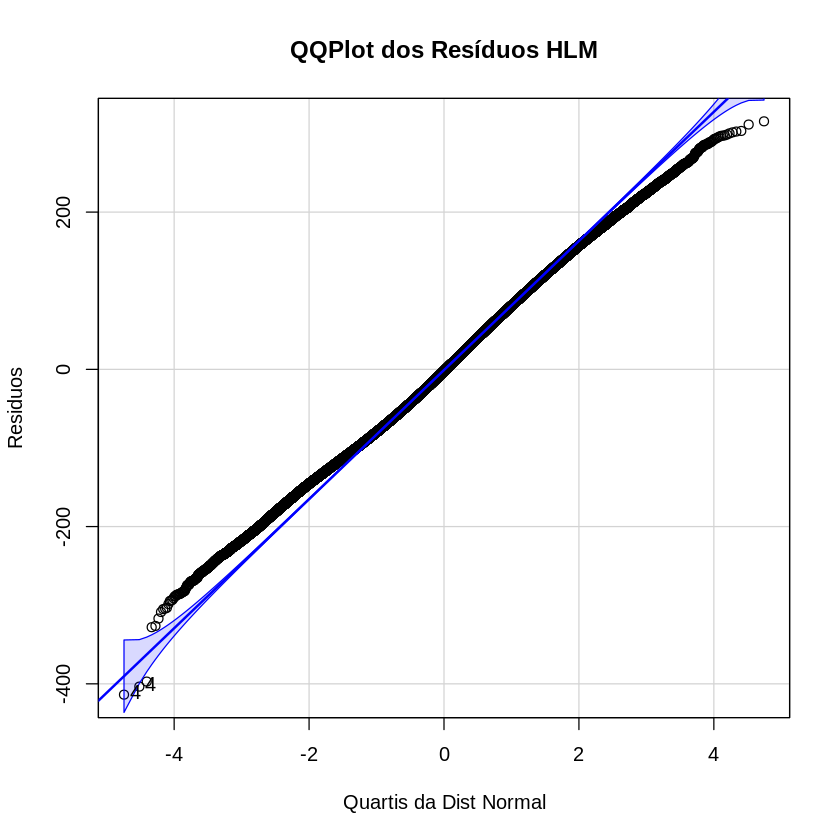

In [ ]:
re_OLS=resid(modelo_OLS_Nulo)
re_HLM=resid(modelo_HLM2_Nulo)
qqPlot(re_OLS, ylab="Residuos", xlab="Quartis da Dist Normal", main = "QQPlot dos Resíduos OLS Nulo")
qqPlot(re_HLM, ylab="Residuos", xlab="Quartis da Dist Normal", main = "QQPlot dos Resíduos HLM Nulo")

[1] 400770 465039

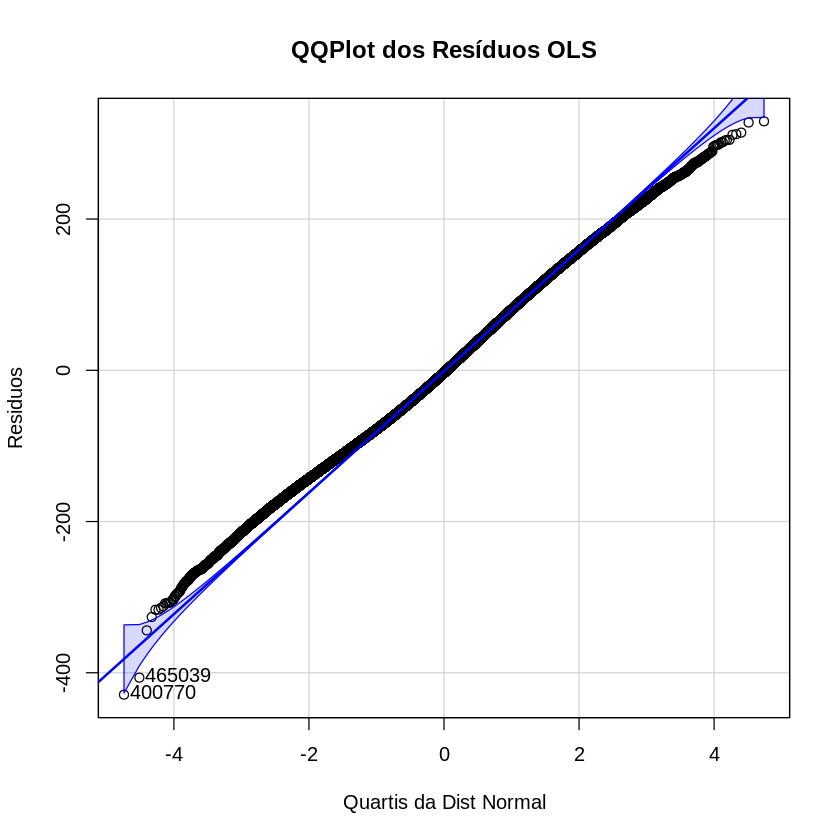

2      4 
400770 465039

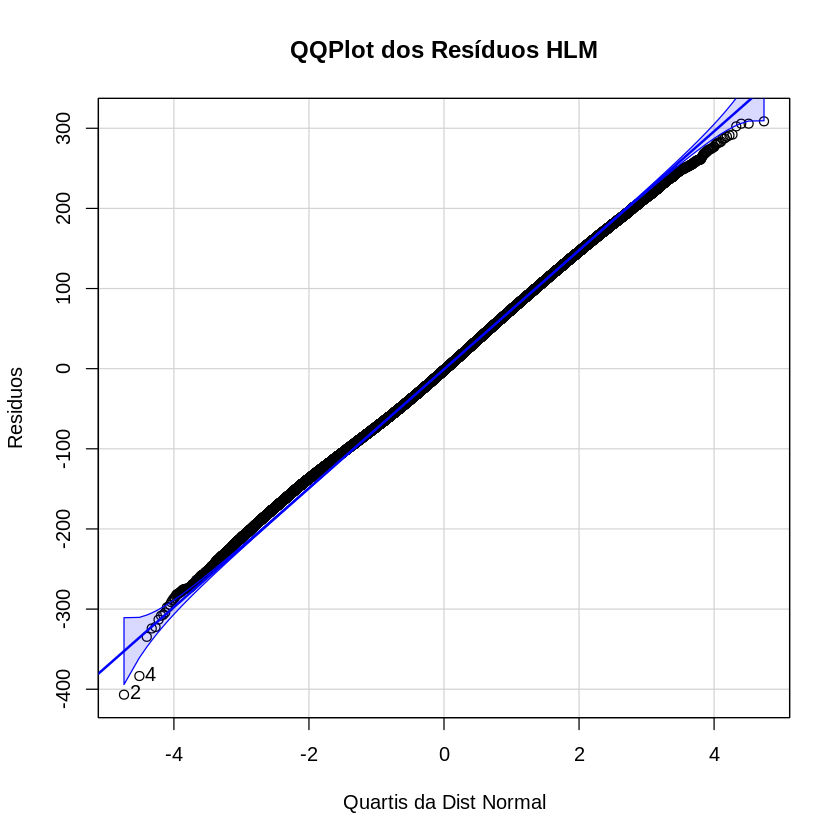

In [ ]:
re_OLS_FINAL=resid(modelo_OLS_Final)
re_HLM_FINAL=resid(modelo_HLM2_final)
qqPlot(re_OLS_FINAL, ylab="Residuos", xlab="Quartis da Dist Normal", main = "QQPlot dos Resíduos OLS Final")
qqPlot(re_HLM_FINAL, ylab="Residuos", xlab="Quartis da Dist Normal", main = "QQPlot dos Resíduos HLM Final")

In [ ]:
#Gerando os fitted values do modelo OLS
base_teste$ols_fitted <- modelo_OLS_Final$fitted.values

#Gerando os fitted values do modelo HLM2 Final
base_teste$hlm2_fitted <- predict(modelo_HLM2,
                                        base_teste)

In [ ]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3732825,199.4,14323649,765.0,22380701,1195.3
Vcells,414694612,3163.9,1220780697,9313.9,1220590346,9312.4


`geom_smooth()` using formula 'y ~ x'



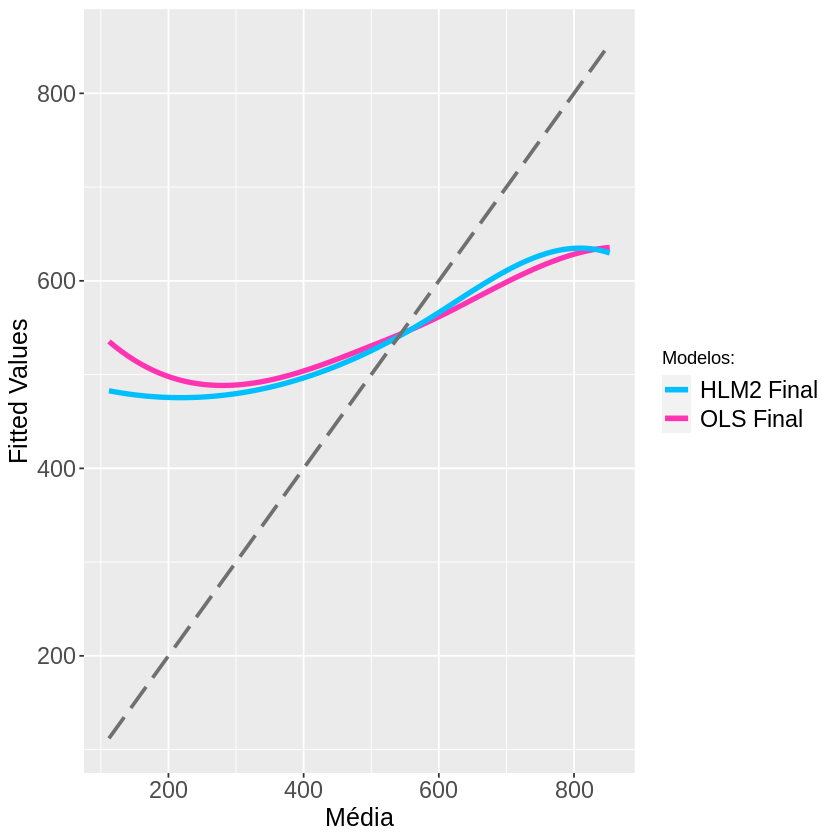

In [ ]:
#Gráfico para a comparação entre os fitted values dos modelos HLM2 Final, OLs
base_teste %>%
  ggplot() +
  geom_smooth(aes(x = NU_MEDIA, y = ols_fitted, color = "OLS Final"),
              method = "lm", se = F, formula = y ~ splines::bs(x, df = 5),
              size = 1.5) +
  geom_smooth(aes(x = NU_MEDIA, y= hlm2_fitted, color = "HLM2 Final"),
              method = "lm", se = F, formula = y ~ splines::bs(x, df = 5),
              size = 1.5) +
  geom_smooth(aes(x = NU_MEDIA, y = NU_MEDIA), method = "lm", 
              color = "gray44", size = 1.05,
              linetype = "longdash") +
  scale_color_manual("Modelos:", 
                     values = c("deepskyblue1", "maroon1", "darkorchid")) +
  labs(x = "Média", y = "Fitted Values") +
  theme(
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 14),
    legend.text = element_text(size = 14)
  )



In [ ]:
residuos <- as.data.frame(re_HLM_FINAL)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



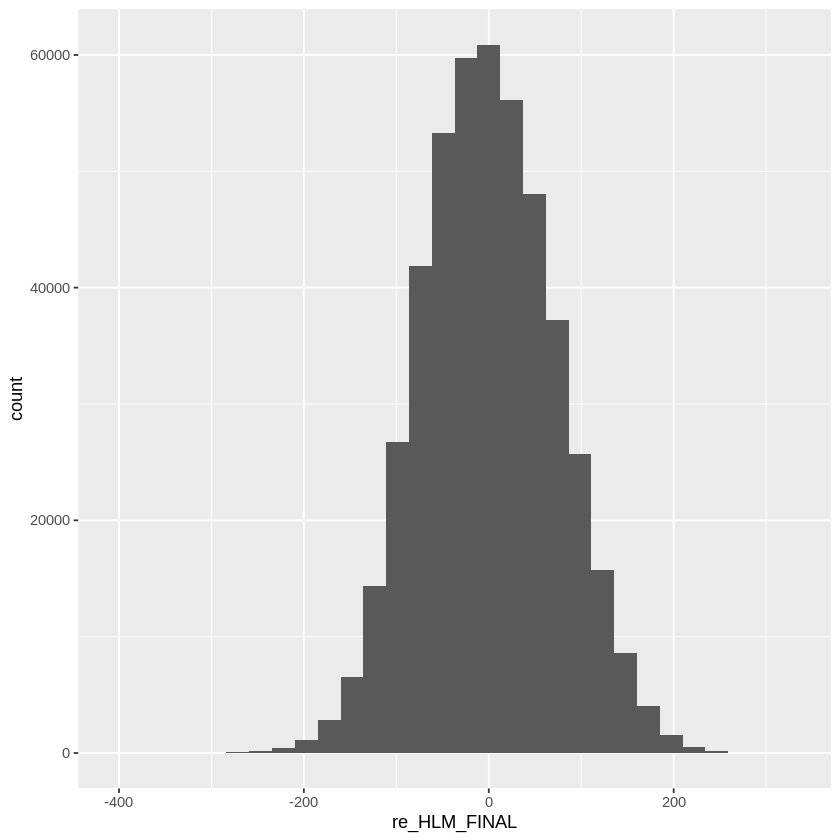

In [ ]:
#Distribuição normal para os resíduos do modelo final de 2 níveis
residuos %>%
  ggplot(aes( x = re_HLM_FINAL)) + 
  geom_histogram()

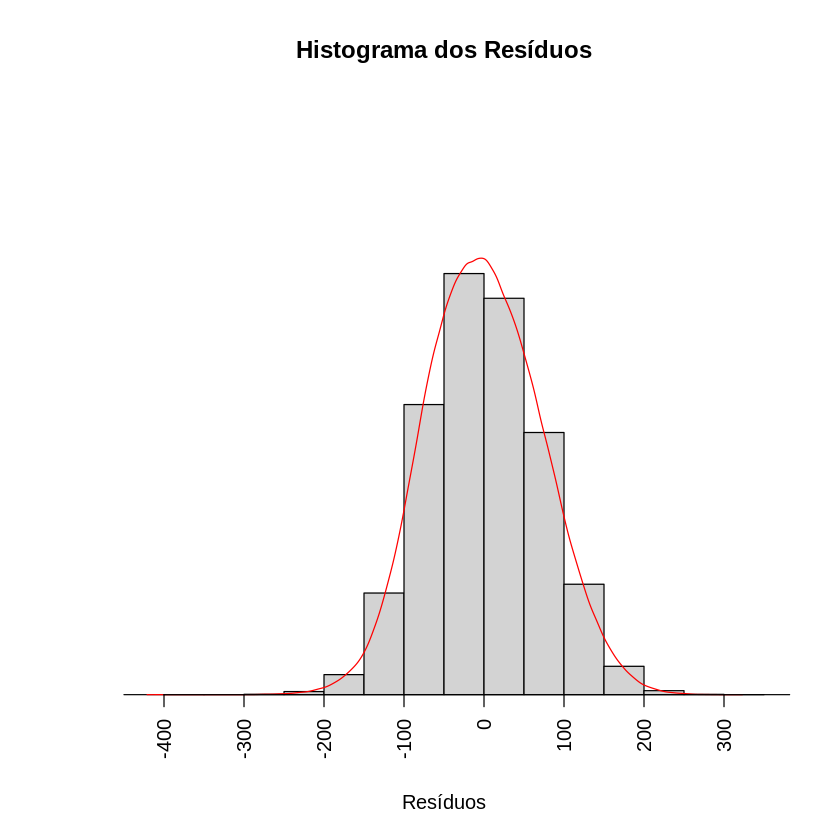

In [ ]:
hist(re_HLM_FINAL, main= "Histograma dos Resíduos", xlab="Resíduos", ylab="", axes=F, ylim=c(0,0.007), prob=T)
lines(density(re_HLM_FINAL), col="red")
axis(1,at = c(-400,-300,-200,-100,0,100,200,300,400), pos=0, las=3)



No id variables; using all as measure variables



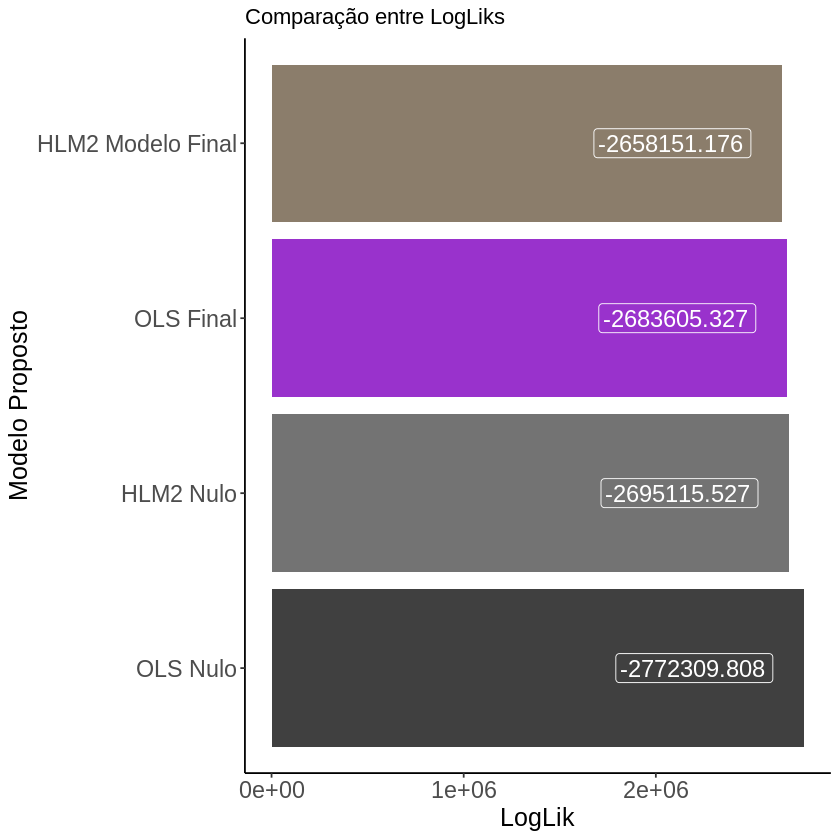

In [ ]:
#Comparação entre os LLs de todos os modelos estimados neste exemplo
data.frame(OLS_Nulo = logLik(modelo_OLS_Nulo),
           HLM2_Nulo = logLik(modelo_HLM2_Nulo),
           OLS_Final = logLik(modelo_OLS_Final),
           HLM2_Modelo_Final = logLik(modelo_HLM2)) %>%
  rename(`OLS Nulo` = 1,
         `HLM2 Nulo` = 2,
         `OLS Final` = 3,
         `HLM2 Modelo Final` = 4) %>%
  melt() %>%
  ggplot(aes(x = variable, y = (abs(-value)), fill = factor(variable))) +
  geom_bar(stat = "identity") +
  geom_label(aes(label = (round(value,3))), hjust = 1.2, color = "white", size = 5) +
  labs(title = "Comparação entre LogLiks", 
       y = "LogLik", 
       x = "Modelo Proposto") +
  coord_flip() +
  scale_fill_manual("Legenda:",
                    values = c("grey25","grey45","darkorchid","bisque4",
                               "maroon1","bisque3","deepskyblue1")) +
  theme(legend.title = element_blank(), 
        panel.background = element_rect("white"),
        legend.position = "none",
        axis.line = element_line(),
        axis.title = element_text(size = 15),
        axis.text = element_text(size = 14),
        legend.text = element_text(size = 14))


`geom_smooth()` using formula 'y ~ x'



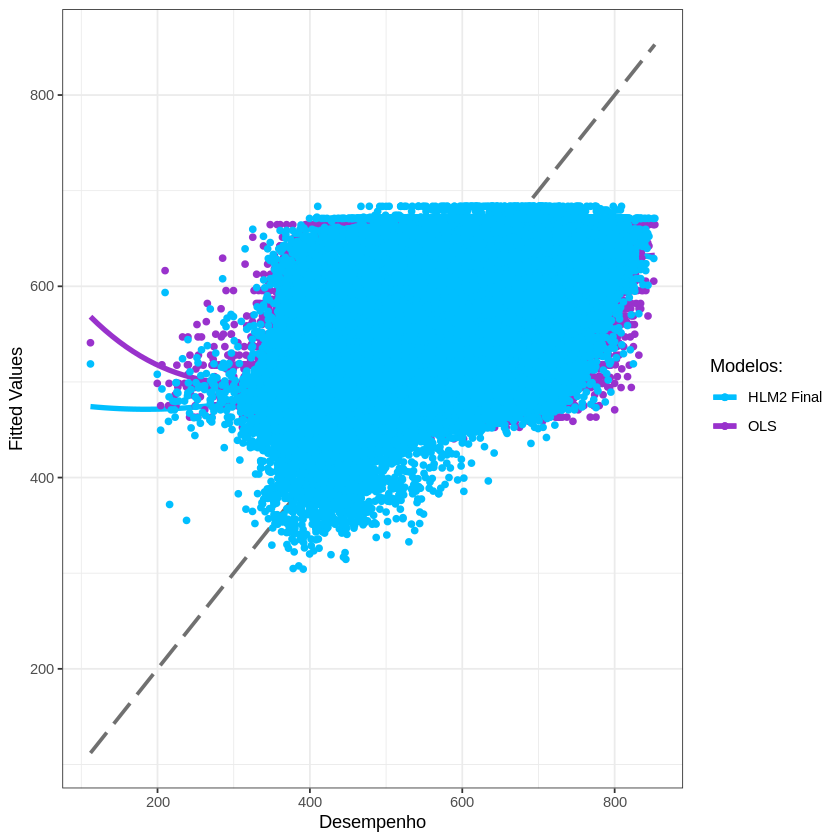

In [ ]:
#Plotagem #PELO AMOR DE DEUS, NÃO USAR ISSO!
base_final %>%
  ggplot() +
  geom_smooth(aes(x = NU_MEDIA, y = ols_fitted, color = "OLS"),
              method = "lm", se = F, formula = y ~ splines::bs(x, df = 5),
              size = 1.5) +
  geom_smooth(aes(x = NU_MEDIA, y= hlm2_fitted, color = "HLM2 Final"),
              method = "lm", se = F, formula = y ~ splines::bs(x, df = 5),
              size = 1.5) +
  geom_smooth(aes(x = NU_MEDIA, y = NU_MEDIA), method = "lm", 
              color = "gray44", size = 1.05,
              linetype = "longdash") +
  geom_point(aes(x = NU_MEDIA, y = ols_fitted,
                 color = "OLS")) +
  geom_point(aes(x = NU_MEDIA, y = hlm2_fitted,
                 color = "HLM2 Final"))  +
  scale_color_manual("Modelos:", 
                     values = c("deepskyblue1","darkorchid")) +
  labs(x = "Desempenho", y = "Fitted Values") +
  theme_bw()